вариант 9

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

Препроцессинг

Солвер

In [12]:
def Explicit_schema(u, a, b, c, tau):
    time_steps, n = u.shape
    for k in range(0, time_steps-1):
        u[k+1, 0] = 0
        u[k+1, n-1] = 0
        for i in range(1, n-1):
            u[k+1, i] = ((a*tau)/(h**2))*(u[k, i-1]-2*u[k, i]+u[k, i+1])+ \
                        ((b*tau)/(2*h))*(u[k, i+1]-u[k, i-1])+ \
                        c*u[k, i]*tau+ \
                        0*tau+ \
                        u[k, i]

def Implicit_schema(u, a, b, c, tau):
    time_steps, n = u.shape
    alpha = (a*tau)/(h**2)-(b*tau)/(2*h)
    beta = -1-2*(a*tau)/(h**2)+c*tau
    gamma = (a*tau)/(h**2)+(b*tau)/(2*h)

    A = np.zeros((n, n))
    A[0, 0] = 1
    A[n-1, n-1] = 1
    for i in range(1, n-1):
        A[i, i-1] = alpha
        A[i, i] = beta
        A[i, i+1] = gamma
    
    for k in range(1, time_steps):
        b = -u[k-1]
        u[k] = np.linalg.solve(A, b)

def Combined_scheme(u, a, b, c, tau):
    tetha = 1/2
    time_steps, n = u.shape
    alpha = ((a*tau)/(h**2)-(b*tau)/(2*h))*(tetha)
    beta = (-1)+(((-2)*a*tau)/(h**2)+c*tau)*(tetha)
    gamma = ((a*tau)/(h**2)+(b*tau)/(2*h))*(tetha)

    A = np.zeros((n, n))
    A[0, 0] = 1
    A[n-1, n-1] = 1
    for i in range(1, n-1):
        A[i, i-1] = alpha
        A[i, i] = beta
        A[i, i+1] = gamma

    for k in range(1, time_steps):
        explicit_part = np.empty(n)
        explicit_part[0] = 0
        explicit_part[-1] = 0
        for i in range(1, n-1):
            explicit_part[i] = ((a*tau)/(h**2))*(u[k-1, i-1]-2*u[k-1, i]+u[k-1, i+1])+ \
                               ((b*tau)/(2*h))*(u[k-1, i+1]-u[k-1, i-1])+ \
                               c*u[k-1, i]*tau+ \
                               0*tau
        d = -u[k-1]-(1-tetha)*explicit_part
        u[k] = np.linalg.solve(A, d)

In [29]:
class Solver:
    def __init__(self, a, b, c, u_start, left_border_condition, right_border_condition, left_border, right_border, n, sigma, end_time) -> None:
        self.a = a
        self.b = b
        self.c = c
        self.u_start = u_start
        self.left_border = left_border
        self.right_border = right_border
        self.l = right_border-left_border

        self.n = n
        self.sigma = sigma
        self.end_time = end_time
        self.h = self.l/(n-1)
        self.time_steps = int((end_time*a*n**2)/(sigma*self.l**2))-1
        self.tau = (sigma*self.l**2)/(a*n**2)

        self.left_border_condition = left_border_condition
        self.right_border_condition = right_border_condition

        self.left_a = 1
        self.left_b = 1
        self.right_a = 1
        self.right_b = 1

    def solve(self, scheme, boundary_conditions_interpolation):
        u = np.zeros((self.time_steps, self.n))
        u[0] = self.u_start(np.linspace(self.left_border, self.right_border+self.h, self.n))
        if scheme == 'explicit':
            for k in range(0, self.time_steps-1):
                for i in range(1, self.n-1):
                    u[k+1, i] = ((self.a*self.tau)/(self.h**2))*(u[k, i-1]-2*u[k, i]+u[k, i+1])+ \
                                ((self.b*self.tau)/(2*self.h))*(u[k, i+1]-u[k, i-1])+ \
                                self.c*u[k, i]*self.tau+ \
                                0*self.tau+ \
                                u[k, i]

                if boundary_conditions_interpolation == '2_points_1st_order':
                    u[k+1, 0] = (self.left_border_condition((k+1)*self.tau, self.a, self.b, self.c)-(self.left_a/self.h)*u[k+1, 1])/(-(self.left_a/self.h)+self.left_b)
                    u[k+1, -1] = (self.right_border_condition((k+1)*self.tau, self.a, self.b, self.c)+(self.right_a/self.h)*u[k+1, -2])/ \
                                       ((self.right_a/self.h)+self.right_b)
                if boundary_conditions_interpolation == '3_points_2nd_order':
                    u[k+1, 0] = (self.left_border_condition((k+1)*self.tau, self.a, self.b, self.c)-((4*self.left_a)/(2*self.h)*u[k+1, 1])+(self.left_a/(2*self.h))*u[k+1, 2])/ \
                                (((-3)*self.left_a)/(2*self.h)+self.left_b)
                    u[k+1, -1] = (self.right_border_condition((k+1)*self.tau, self.a, self.b, self.c)+((4*self.right_a)/(2*self.h)*u[k+1, -2])-(self.right_a/(2*self.h))*u[k+1, -3])/ \
                                       ((3*self.right_a)/(2*self.h)+self.right_b)
                if boundary_conditions_interpolation == '2_points_2nd_order':
                    u[k+1, 0] = (self.left_border_condition((k+1)*self.tau, self.a, self.b, self.c)-u[k+1, 1]*(self.left_a/(self.h-(self.b*self.h**2)/(2*self.a)))-u[k, 0]*(self.left_a/(self.h-(self.b*self.h**2)/(2*self.a)))*(self.h**2/(2*self.a*self.tau)))/((self.left_a/(self.h-(self.b*self.h**2)/(2*self.a)))*(-1-(self.h**2)/(2*self.a*self.tau)+(self.c*self.h**2)/(2*self.a))+self.left_b)
                    u[k+1, -1] = (self.right_border_condition((k+1)*self.tau, self.a, self.b, self.c)-u[k+1, -2]*(self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))-u[k, -1]*(self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))*(self.h**2/(2*self.a*self.tau)))/((self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))*(-1-(self.h**2)/(2*self.a*self.tau)+(self.c*self.h**2)/(2*self.a))+self.right_b)

        if scheme == 'implicit':
            alpha = ((self.a*self.tau)/(self.h**2))-((self.b*self.tau)/(2*self.h))
            beta = -1-(2*(self.a*self.tau)/(self.h**2))+(self.c*self.tau)
            gamma = ((self.a*self.tau)/(self.h**2))+((self.b*self.tau)/(2*self.h))

            A = np.zeros((self.n, self.n))
            if boundary_conditions_interpolation == '2_points_1st_order':
                A[0, 0] = (-(self.left_a/self.h)+self.left_b)
                A[0, 1] = (self.left_a/self.h)
                A[-1, -1] = ((self.right_a/self.h)+self.right_b)
                A[-1, -2] = -(self.right_a/self.h)
            if boundary_conditions_interpolation == '3_points_2nd_order':
                A[0, 0] = (((-3)*self.left_a)/(2*self.h)+self.left_b)
                A[0, 1] = (4*self.left_a)/(2*self.h)
                A[0, 2] = (-self.left_a)/(2*self.h)
                A[-1, -1] = ((3*self.right_a)/(2*self.h)+self.right_b)
                A[-1, -2] = ((-4)*self.right_a)/(2*self.h)
                A[-1, -3] = (self.right_a)/(2*self.h)
            if boundary_conditions_interpolation == '2_points_2nd_order':
                A[0, 0] = (self.left_a/(self.h-(self.b*self.h**2)/(2*self.a)))*(-1-(self.h**2)/(2*self.a*self.tau)+(self.c*self.h**2)/(2*self.a))+self.left_b
                A[0, 1] = self.left_a/(self.h-(self.b*self.h**2)/(2*self.a))
                A[-1, -1] = ((self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))*(-1-(self.h**2)/(2*self.a*self.tau)+(self.c*self.h**2)/(2*self.a))+self.right_b)
                A[-1, -2] = (self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))
            for i in range(1, self.n-1):
                A[i, i-1] = alpha
                A[i, i] = beta
                A[i, i+1] = gamma
            
            for k in range(1, self.time_steps):
                d = -u[k-1].copy()
                d[0] = self.left_border_condition(k*self.tau, self.a, self.b, self.c)
                d[-1] = self.right_border_condition(k*self.tau, self.a, self.b, self.c)
                if boundary_conditions_interpolation == '2_points_2nd_order':
                    d[0] -= u[k-1, 0]*(self.left_a/(self.h-(self.b*self.h**2)/(2*self.a)))*(self.h**2/(2*self.a*self.tau))
                    d[-1] -= u[k-1, -1]*(self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))*(self.h**2/(2*self.a*self.tau))
                u[k] = np.linalg.solve(A, d)
        if scheme == 'combined':
            tetha = 1/2
            alpha = ((self.a*self.tau)/(self.h**2)-(self.b*self.tau)/(2*self.h))*(tetha)
            beta = (-1)+(((-2)*self.a*self.tau)/(self.h**2)+self.c*self.tau)*(tetha)
            gamma = ((self.a*self.tau)/(self.h**2)+(self.b*self.tau)/(2*self.h))*(tetha)

            A = np.zeros((self.n, self.n))
            if boundary_conditions_interpolation == '2_points_1st_order':
                A[0, 0] = (-(self.left_a/self.h)+self.left_b)
                A[0, 1] = (self.left_a/self.h)
                A[-1, -1] = ((self.right_a/self.h)+self.right_b)
                A[-1, -2] = -(self.right_a/self.h)
            if boundary_conditions_interpolation == '3_points_2nd_order':
                A[0, 0] = (((-3)*self.left_a)/(2*self.h)+self.left_b)
                A[0, 1] = (4*self.left_a)/(2*self.h)
                A[0, 2] = (-self.left_a)/(2*self.h)
                A[-1, -1] = ((3*self.right_a)/(2*self.h)+self.right_b)
                A[-1, -2] = ((-4)*self.right_a)/(2*self.h)
                A[-1, -3] = (self.right_a)/(2*self.h)
            if boundary_conditions_interpolation == '2_points_2nd_order':
                A[0, 0] = (self.left_a/(self.h-(self.b*self.h**2)/(2*self.a)))*(-1-(self.h**2)/(2*self.a*self.tau)+(self.c*self.h**2)/(2*self.a))+self.left_b
                A[0, 1] = self.left_a/(self.h-(self.b*self.h**2)/(2*self.a))
                A[-1, -1] = ((self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))*(-1-(self.h**2)/(2*self.a*self.tau)+(self.c*self.h**2)/(2*self.a))+self.right_b)
                A[-1, -2] = (self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))
            for i in range(1, self.n-1):
                A[i, i-1] = alpha
                A[i, i] = beta
                A[i, i+1] = gamma

            for k in range(1, self.time_steps):
                explicit_part = np.empty(self.n)
                for i in range(1, self.n-1):
                    explicit_part[i] = ((self.a*self.tau)/(self.h**2))*(u[k-1, i-1]-2*u[k-1, i]+u[k-1, i+1])+ \
                                       ((self.b*self.tau)/(2*self.h))*(u[k-1, i+1]-u[k-1, i-1])+ \
                                       self.c*u[k-1, i]*self.tau+ \
                                       0*self.tau
                if boundary_conditions_interpolation == '2_points_1st_order':
                    explicit_part[0] = (self.left_border_condition(k*self.tau, self.a, self.b, self.c)-(self.left_a/self.h)*explicit_part[1])/(-(self.left_a/self.h)+self.left_b)
                    explicit_part[self.n-1] = (self.right_border_condition(k*self.tau, self.a, self.b, self.c)+(self.right_a/self.h)*explicit_part[-2])/ \
                                       ((self.right_a/self.h)+self.right_b)
                if boundary_conditions_interpolation == '3_points_2nd_order':
                    explicit_part[0] = (self.left_border_condition(k*self.tau, self.a, self.b, self.c)-((4*self.left_a)/(2*self.h)*explicit_part[1])+(self.left_a/(2*self.h))*explicit_part[2])/ \
                                (((-3)*self.left_a)/(2*self.h)+self.left_b)
                    explicit_part[self.n-1] = (self.right_border_condition(k*self.tau, self.a, self.b, self.c)+((4*self.right_a)/(2*self.h)*explicit_part[-2])-(self.right_a/(2*self.h))*explicit_part[-3])/ \
                                       ((3*self.right_a)/(2*self.h)+self.right_b)
                if boundary_conditions_interpolation == '2_points_2nd_order':
                    explicit_part[0] = (self.left_border_condition((k)*self.tau, self.a, self.b, self.c)-explicit_part[1]*(self.left_a/(self.h-(self.b*self.h**2)/(2*self.a)))-u[k-1, 0]*(self.left_a/(self.h-(self.b*self.h**2)/(2*self.a)))*(self.h**2/(2*self.a*self.tau)))/((self.left_a/(self.h-(self.b*self.h**2)/(2*self.a)))*(-1-(self.h**2)/(2*self.a*self.tau)+(self.c*self.h**2)/(2*self.a))+self.left_b)
                    explicit_part[-1] = (self.right_border_condition((k)*self.tau, self.a, self.b, self.c)-explicit_part[-2]*(self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))-u[k-1, -1]*(self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))*(self.h**2/(2*self.a*self.tau)))/((self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))*(-1-(self.h**2)/(2*self.a*self.tau)+(self.c*self.h**2)/(2*self.a))+self.right_b)


                d = -u[k-1].copy()
                d[0] = self.left_border_condition(k*self.tau, self.a, self.b, self.c)
                d[-1] = self.right_border_condition(k*self.tau, self.a, self.b, self.c)
                if boundary_conditions_interpolation == '2_points_2nd_order':
                    d[0] -= u[k-1, 0]*(self.left_a/(self.h-(self.b*self.h**2)/(2*self.a)))*(self.h**2/(2*self.a*self.tau))
                    d[-1] -= u[k-1, -1]*(self.right_a/(-self.h-(self.b*self.h**2)/(2*self.a)))*(self.h**2/(2*self.a*self.tau))
                d = d-(1-tetha)*explicit_part
                u[k] = np.linalg.solve(A, d)
        return u

In [30]:
def U_start(x):
    return np.sin(x)

def Left_border_condition(t, a, b, c):
    return np.exp((c-a)*t)*(np.cos(b*t)+np.sin(b*t))
def Right_border_condition(t, a, b, c):
    return -np.exp((c-a)*t)*(np.cos(b*t)+np.sin(b*t))

a = 1
b = 2
c = -20
left_border = 0
right_border = math.pi

n = 20
sigma = 0.5

end_time = 0.2

solver = Solver(a, b, c, U_start, Left_border_condition, Right_border_condition, left_border, right_border, n, sigma, end_time)
# u = solver.solve('explicit', '2_points_1st_order')
# u = solver.solve('explicit', '2_points_2nd_order')
# u = solver.solve('implicit', '2_points_2nd_order')
u = solver.solve('combined', '2_points_2nd_order')
# u = solver.solve('combined', '2_points_1st_order')

In [24]:
u.shape

(15, 20)

In [31]:
[left_border+solver.h*i for i in range(0, n)]

[0.0,
 0.16534698176788384,
 0.3306939635357677,
 0.4960409453036515,
 0.6613879270715354,
 0.8267349088394192,
 0.992081890607303,
 1.1574288723751869,
 1.3227758541430708,
 1.4881228359109546,
 1.6534698176788385,
 1.8188167994467224,
 1.984163781214606,
 2.14951076298249,
 2.3148577447503738,
 2.4802047265182576,
 2.6455517082861415,
 2.8108986900540254,
 2.9762456718219092,
 3.141592653589793]

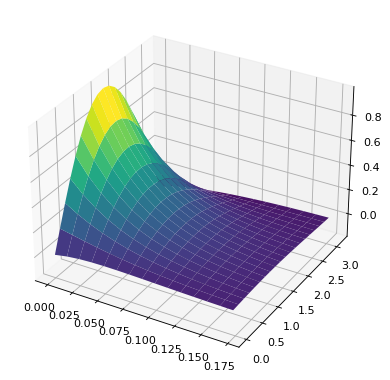

In [32]:
X = np.array([[solver.tau*k for i in range(0, n)] for k in range(solver.time_steps)])
Y = np.array([[left_border+solver.h*i for i in range(0, n)] for k in range(solver.time_steps)])
Z = np.array([[u[k, i] for i in range(0, n)] for k in range(solver.time_steps)])


plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')